## 3DVar
cost function
$
J(x) = \frac{1}{2}(x-x^{b})^{T}B^{-1}(x-x^{b}) + \frac{1}{2}(y^{o}-Hx^{b})^{T}R^{-1}(y^{o}-Hx^{b})
$

$
x^{a} = x^{b} + (B^{-1} + H^{T}R^{-1}H)^{-1}H^{T}R^{-1}(y^{o}-Hx^{b})
$

In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import csv

### OI（最適内挿法）

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
0.4045803532242309


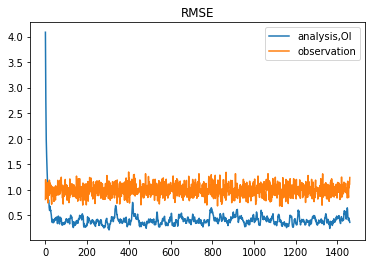

In [11]:
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb


def Forecast(Xa,B):
    h = 0.05 
    F = 8.0
    
    Xf = Rungekutta4(Xa,h,F)
    
    Pf = B #カルマンフィルターでは時間発展する、3次元変分法では定数
    
    
    return Xf,Pf

def Analysis(Xf,Pf,y,N):
    H = np.eye(N)
    R = np.eye(N)
    I = np.eye(N)
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    
    Xa = Xf + K @ (y - H @ Xf)
    Pa = (I - K @ H)@ Pf
    
    return Xa

t = 1460
N = 40
h = 0.05 
F = 8.0
#初期値
Xa = np.random.randn(N)
X0 = Xa
for j in range(500):
    Xa = Rungekutta4(X0,h,F)
    X0 = Xa
Pa = np.eye(N) * 25
#print(Xa)
#print(Pa)
  
dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)

X = []
P = []
errcov = []
B = np.eye(N)*0.2
for k in range(t):
    #print(y[k])
    (Xf,Pf) = Forecast(Xa,B)
    Xa = Analysis(Xf,Pf,y[k,:],N)
    X.append(Xa)
    if(k%100==0):
        print(k)
    
Xa = np.array(X)
#print(Xa)

C1_ = []
C2_ = []
C3_ = []
H = np.eye(N)
for i in range(1460):
    X1 = Xa[i]
    X2 = Xt[i]
    X3 = sum((X2-X1)*(X2-X1))/N
    Y1 = y[i]
    Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    rmse1 = np.sqrt(X3)
    rmse2 = np.sqrt(Y2)
    C1_.append(rmse1)
    C2_.append(rmse2)
    
ERR = np.array(C1_)
print(np.mean(ERR[200:]))
plt.plot(C1_,label="analysis,OI")
plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
plt.legend()
plt.title("RMSE")
plt.savefig("OI.jpg")
plt.show()

In [6]:
def inflation(a):
    t = 1460
    N = 40
    h = 0.05 
    F = 8.0
    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #for i in range(N):
        #Xa[i] += random.random()
    Pa = np.eye(N) * 25
    #print(Xa)
    #print(Pa)
    
    dataset = pd.read_csv("observation_data.csv")
    y = dataset.values
    y = y.reshape(1460,N)
    X = []
    P = []
    errcov = []
    B = np.eye(N)*a
    for k in range(t):
        (Xf,Pf) = Forecast(Xa,Pa,B,N)
        (Xa,Pa) = Analysis(Xf,Pf,y[k,:],N)
        X.append(Xa)
        P.append(Pa)
        err = 0
        err = np.sqrt(np.sum(np.diag(Pa))/N)
        errcov.append(err)
            
    return X,errcov

1
2
3
4
5
6
7
8
9


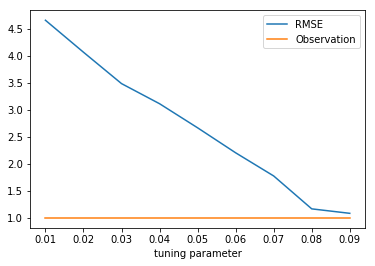

[4.657396234901667, 4.0651078205623215, 3.4836694957852794, 3.110888186068947, 2.6646100480852692, 2.2015766129110323, 1.7724240281035422, 1.1628880114496776, 1.0802583643174641]


In [11]:
N=40
dataset = pd.read_csv("observation_data.csv")
y = dataset.values.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values
delta = []
R = []
RO = []
T = []
for i in range(1):
    print(i)
    a = 0.2
    (X,errcov) = inflation(a)
    X_ = np.array(X)
    C1 = []
    N=40
    rmse = 0
    rmse2 = 0
    trPa = 0
    num = 0
    for i in range(500,1460):
        num += 1
        X1 = X_[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i,:]
        Y2 = sum((X2-Y1)*(X2-Y1))/N
        rmse += np.sqrt(X3)
        rmse2 += np.sqrt(Y2)
        trPa += errcov[i]
    rmse = rmse/num
    rmse2 = rmse2/num
    trPa = trPa/num
    
    delta.append(a)
    R.append(rmse)
    RO.append(rmse2)
    T.append(trPa)

plt.plot(delta,R,label="RMSE")
plt.plot(delta,RO,label="Observation")
#plt.plot(delta,T,label="trPa")
plt.xlabel("tuning parameter")
plt.legend()
#plt.savefig("tuning3d.jpg")
plt.show()
print(R)

1
960
2
960
3
960
4
960
5
960
6
960
7
960
8
960
9
960
10
960
11
960
12
960
13
960
14
960
15
960
16
960
17
960
18
960
19
960
20
960
21
960
22
960
23
960
24
960
25
960
26
960
27
960
28
960
29
960
30
960
31
960
32
960
33
960
34
960
35
960
36
960
37
960
38
960
39
960
40
960
41
960
42
960
43
960
44
960
45
960
46
960
47
960
48
960
49
960
50
960
51
960
52
960
53
960
54
960
55
960
56
960
57
960
58
960
59
960
60
960
61
960
62
960
63
960
64
960
65
960
66
960
67
960
68
960
69
960
70
960
71
960
72
960
73
960
74
960
75
960
76
960
77
960
78
960
79
960
80
960
81
960
82
960
83
960
84
960
85
960
86
960
87
960
88
960
89
960
90
960
91
960
92
960
93
960
94
960
95
960
96
960
97
960
98
960
99
960
100
960


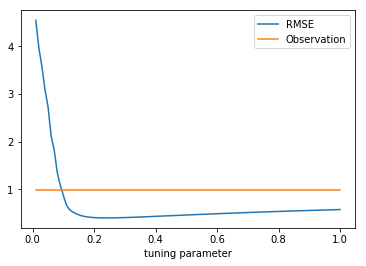

[4.547340597146994, 3.967811281209519, 3.5720433231729745, 3.0853188052094613, 2.72451825037083, 2.114954066734842, 1.8238188057749178, 1.3466773710138915, 1.0801862979263563, 0.8638195042910539, 0.6666623095158307, 0.5728247510474707, 0.5280565890321719, 0.4942739785097677, 0.4659104944044074, 0.4454938213465337, 0.43118654348608393, 0.420999120283615, 0.41379316087119883, 0.4087945090923327, 0.40545700191629896, 0.4033898660703061, 0.4023073501800605, 0.4019963718573551, 0.4022956745062866, 0.4030817733404318, 0.4042590938711862, 0.40575289412434273, 0.4075041262895021, 0.4094656787472833, 0.4115996080699103, 0.4138750836486028, 0.4162668475702611, 0.41875404943720984, 0.42131935628547434, 0.423948266230173, 0.42662857444212476, 0.42934995410421073, 0.4321036249340296, 0.43488208895600733, 0.4376789183263076, 0.44048858374677474, 0.44330631475247523, 0.44612798519908325, 0.44895001880528246, 0.45176931075862387, 0.45458316226891804, 0.45738922562214995, 0.4601854578018614, 0.46297008

In [13]:
N=40
dataset = pd.read_csv("observation_data.csv")
y = dataset.values.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values
delta = []
R = []
RO = []
T = []
for i in range(1,101):
    print(i)
    a = 0 + 0.01*i
    (X,errcov) = inflation(a)
    X_ = np.array(X)
    C1 = []
    N=40
    rmse = 0
    rmse2 = 0
    trPa = 0
    num = 1460-500
    X1 = X_[500:1460,:]
    X2 = Xt[500:1460,:]
    X3 = np.sum((X2-X1)*(X2-X1),axis=1)/N
    #print(X3.size)
    Y1 = y[500:1460,:]
    Y2 = np.sum((X2-Y1)*(X2-Y1),axis=1)/N
    trPa += errcov[i]
    rmse = np.sum(np.sqrt(X3))/num
    rmse2 = np.sum(np.sqrt(Y2))/num
    trPa = trPa/num
    
    delta.append(a)
    R.append(rmse)
    RO.append(rmse2)
    T.append(trPa)

    
plt.plot(delta,R,label="RMSE")
plt.plot(delta,RO,label="Observation")
#plt.plot(delta,T,label="trPa")
plt.xlabel("tuning parameter")
plt.legend()
#plt.savefig("tuning3d.jpg")
plt.show()
print(R)

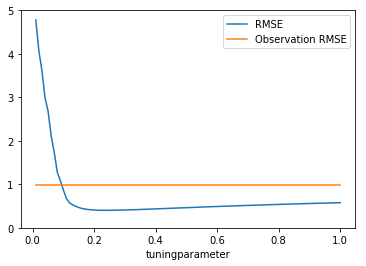

In [5]:
plt.plot(delta,R,label="RMSE")
plt.plot(delta,RO,label="Observation RMSE")
plt.xlabel("tuningparameter")
plt.ylim([0.0,5.0])
plt.legend()
plt.savefig("tuning3d.jpg")
plt.show()

### 3DVar

In [8]:
#Gradient descent
def GD(A,b):
    x0 = b
    r = b - A@x0
    p = r
    for k in range(10000):
        a = np.dot(p,r)/np.dot(p,A@p)
        x = x0 + a*p
        r = b - A@x
        p = r
        x0 = x
        #print(a,x,r)
        err = np.sqrt(np.dot(r,r))
        if(err<1e-7):
            break
    return x

#Conjucate Gradient
def CG(A,b):
    x0 = b
    r0 = b - A@x0
    p0 = r0
    for k in range(10000):
        a = np.dot(p0,r0)/np.dot(p0,A@p0)
        x = x0 + a*p0
        r = r0 - a*A@p0
        err = np.sqrt(np.dot(r,r))
        #print(err)
        if(err<1e-7):
            break
        y = r-r0
        beta = -np.dot(r,y)/np.dot(p0,y)
        p = r + beta*p0
    
        x0 = x
        p0 = p
        r0 = r
    return x

def golden_section_N(x0,G0,B_inv,H_t,R_inv,d):
    a0=-10
    b0=10
    t = 0.618 #golden_ratio
    a=a0
    b=b0
    c1=(a+b)/2-1
    c2=(a+b)/2+1
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        x1 = x0 - c1*G0@jacobi(x0,B_inv,H_t,R_inv,d)
        f1 = J(x1,B_inv,H_t,R_inv,d)
        #f1 = f(c1)
        x2 = x0 - c2*G0@jacobi(x0,B_inv,H_t,R_inv,d)
        f2 = J(x2,B_inv,H_t,R_inv,d)
        #f2 = f(c2)
        if(f2>f1):
            a=a
            b=c2
            c2_=c1
            c1_=a+(1-t)*(b-a)
        else:
            a=c1
            b=b
            c1_=c2
            c2_=b-(1-t)*(b-a)
        if(abs(b-a)<0.0001):
            #print(num,"end")
            break
        c1 = min(c1_,c2_)
        c2 = max(c1_,c2_)
        #print(num,a,b,c1,c2,abs(b-a))
    return a  

def quasi_Newton(start,B_inv,H_t,R_inv,d):
    I=np.eye(N)
    G0=np.eye(N)
    x0 = start
    result=[start]
    for k in range(10000):
        alpha = golden_section_N(x0,G0,B_inv,H_t,R_inv,d)
        x = x0 - alpha*G0@jacobi(x0,B_inv,H_t,R_inv,d)
        
        result.append(x)
        grad = jacobi(x,B_inv,H_t,R_inv,d)
        if(np.sqrt(np.sum(grad**2)/N)<0.001):
            print(k,"end")
            break
        p0 = x - x0
        q0 = grad - jacobi(x0,B_inv,H_t,R_inv,d)
        print(p0,q0)
        #p0 = p0.reshape(-1,1)
        #q0 = q0.reshape(-1,1)
        G = (I - p0@q0.T/q0.T@p0)@G0@(I - q0@p0.T/q0.T@p0) + p0@p0.T/q0.T@p0
        print(G)
        G0 = G
        x0 = x
        
    return x

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
0.40458035325255765


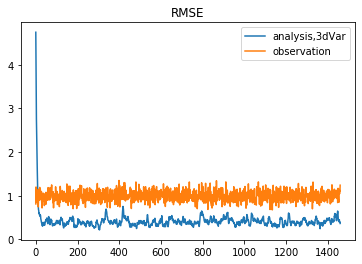

In [9]:
#3dVar
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def J(x,B_inv,H_t,R_inv,d):
    return x.T@B_inv@x/2 + (H_t@x-d).T@R_inv@(H_t@x-d)/2

def jacobi(x,B_inv,H_t,R_inv,d):
    return B_inv@x + H_t.T@R_inv@(H_t@x-d)

def Forecast(Xa,B):
    h = 0.05
    F = 8.0
    
    Xf = Rungekutta4(Xa,h,F)
    
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,Pf,y):
    H = np.eye(N)
    mask = y>=0
    y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    R = np.eye(N)
    I = np.eye(N)
    
    
    d = y - H @ Xf
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(Pf)
    
    A = B_inv + H.T @ R_inv @ H
    b = H.T @ R @ d
    X = CG(A,b)
    #X = quasi_Newton(b,B_inv,H2,R_inv,d)
    Xa = X + Xf
    
    return Xa


t = 1460
N = 40
h = 0.05 
F = 8.0

X = []
P = []
Pt2 = []
P2 = []
errcov = []

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)

#初期値
Xa = np.random.randn(N)
X0 = Xa
for j in range(500):
    Xa = Rungekutta4(X0,h,F)
    X0 = Xa
B = np.eye(N) * 0.2
#print(Xa)
#print(B)
#X.append(Xa
    

for k in range(t):
    #print(y[k])
    (Xf,Pf) = Forecast(Xa,B)
    Xa = Analysis(Xf,Pf,y[k,:])
    X.append(Xa)
    if(k%100==0):
        print(k)
    
Xa = np.array(X)
#print(Xa)

C1_ = []
C2_ = []
C3_ = []
H = np.eye(N)
for i in range(1460):
    X1 = Xa[i]
    X2 = Xt[i]
    X3 = sum((X2-X1)*(X2-X1))/N
    X4 = (X2-X1)*(X2-X1)/N
    Y1 = y[i]
    Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    rmse1 = np.sqrt(X3)
    rmse2 = np.sqrt(Y2)
    rmse3 = np.sqrt(X4)
    C1_.append(rmse1)
    C2_.append(rmse2)
    C3_.append(rmse3)
    
ERR = np.array(C1_)
print(np.mean(ERR[200:]))
plt.plot(C1_,label="analysis,3dVar")
plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
plt.legend()
plt.title("RMSE")
plt.savefig("3dVar.jpg")
plt.show()

### 観測欠損の実験

In [2]:
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,Pa,B,N):
    h = 0.01 
    F = 8.0
    
    X1 = Xa
    #M = np.eye(N)
    for i in range(5):
        Xf = Rungekutta4(X1,h,F)
        #M_ = get_linear(X1,h,F)
        #M = M_ @ M
        X1 = Xf
    
    #M = get_linear(Xa,h,F,N)
    Pf = B #カルマンフィルターでは時間発展する、3次元変分法では定数
    
    
    return Xf,Pf

def Analysis(Xf,Pf,y,N,m,a):
    p = N-a
    matrix = np.identity(N)
    df = pd.DataFrame(matrix) 
    df2 = df.drop(m) #観測欠損
    H = df2.values #観測行列
    R = np.eye(p)
    I = np.eye(N)
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    
    Xa = Xf + K @ (y - H @ Xf)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Pa

def get_linear(Xa,h,F,N):
    d = 0.00001
    E = np.eye(N)
    MT = []
    MT = [(Rungekutta4(Xa+d*E[j],h,F)-Rungekutta4(Xa,h,F))/d for j in range(N)]
        
    M = np.array(MT).reshape(N,N)
    M = M.T
    return M

def inflation3d(a,b):
    t = 1460
    N = 40
    h = 0.01 
    F = 8.0
    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    Pa = np.eye(N) * 25
    #print(Xa)
    #print(Pa)
    
    X = []
    P = []
    errcov = []
    B = np.eye(N)*(b*0.05)
    for k in range(t):
         #観測を減らす
        dataset = pd.read_csv("observation_data.csv")    
        l = np.arange(N).tolist()
        m = random.sample(l,a)
        for i in range(a):
            df = dataset.drop(str(m[i]),axis=1)
            dataset = df
        y = dataset.values 
        y = y.reshape(1460,N-a)
        (Xf,Pf) = Forecast(Xa,Pa,B,N)
        (Xa,Pa) = Analysis(Xf,Pf,y[k,:],N,m,a)
        X.append(Xa)
        P.append(Pa)
        err = 0
        err = np.sqrt(np.sum(np.diag(Pa))/N)
        errcov.append(err)
            
    return X

In [3]:
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def ForecastKF(Xa,Pa,N):
    h = 0.01 
    F = 8.0
    alpha = 1.05
    
    X1 = Xa
    #M = np.eye(N)
    for i in range(5):
        Xf = Rungekutta4(X1,h,F)
        #M_ = get_linear(X1,h,F)
        #M = M_ @ M
        X1 = Xf
    
    M = get_linear(Xa,h,F,N)
    Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = Pf * alpha
    
    return Xf,Pf

def AnalysisKF(Xf,Pf,y,N,m,a):
    p = N-a
    matrix = np.identity(N)
    df = pd.DataFrame(matrix) 
    df2 = df.drop(m) #観測欠損
    H = df2.values #観測行列
    R = np.eye(p)
    I = np.eye(N)
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    
    Xa = Xf + K @ (y - H @ Xf)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Pa

def get_linear(Xa,h,F,N):
    d = 0.00001
    E = np.eye(N)
    MT = []
    MT = [(Rungekutta4(Xa+d*E[j],h*5,F)-Rungekutta4(Xa,h*5,F))/d for j in range(N)]
        
    M = np.array(MT).reshape(N,N)
    M = M.T
    return M

def inflationKF(a):
    t = 1460
    N = 40
    h = 0.01 
    F = 8.0
    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    Pa = np.eye(N) * 25
    #print(Xa)
    #print(Pa)
    
    dataset = pd.read_csv("observation_data.csv")
    #観測を減らす
    l = np.arange(N).tolist()
    m = random.sample(l,a)
    for i in range(a):
        df = dataset.drop(str(m[i]),axis=1)
        dataset = df
    y = dataset.values 
    y = y.reshape(1460,N-a)
    X = []
    P = []
    errcov = []
    for k in range(t):
        (Xf,Pf) = ForecastKF(Xa,Pa,N)
        (Xa,Pa) = AnalysisKF(Xf,Pf,y[k,:],N,m,a)
        X.append(Xa)
        P.append(Pa)
        err = 0
        err = np.sqrt(np.sum(np.diag(Pa))/N)
        errcov.append(err)
            
    return X

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
N=40
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values
Xt_ = Xt[500:1460,:]

def calc_3d(a,b):
    rmse = 0
    X3d = inflation3d(a,b)
    X_ = np.array(X3d)
    num = 1460-500
    X1 = X_[500:1460,:]
    X2 = Xt[500:1460,:]
    X3 = np.sum((X2-X1)*(X2-X1),axis=1)/N
    rmse += np.sum(np.sqrt(X3))/(num*10)
        
    return rmse

def calc_KF(a):
    rmse2 = 0
    for k in range(10):
        XKF = inflationKF(a)
        X_2 = np.array(XKF)
        num = 1460-500
        X2 = Xt[500:1460,:]
        Y1 = X_2[500:1460,:]
        Y2 = np.sum((X2-Y1)*(X2-Y1),axis=1)/N
        rmse2 += np.sum(np.sqrt(Y2))/(num*10)
        
        print(k)
    return rmse2

alpha = [i for i in range(21)]
beta = [i for i in range(40)]
R3d=[[calc_3d(a,b) for a in alpha]for b in beta]
#RKF=[calc_KF(a) for a in delta]

print(R3d)
df = pd.DataFrame(R3d)
df.to_csv("3DVar.csv",index=False)


[[2.44701947 2.61707887 2.68370385 ... 5.0831631  4.93023488 5.02370501]
 [0.86344067 0.9187472  0.96268068 ... 4.60394098 4.9311929  4.88394503]
 [0.46583121 0.49091432 0.49647814 ... 4.49357822 4.90615431 5.02107344]
 ...
 [0.69470023 0.6964651  0.69521891 ... 4.21188031 4.4774625  4.72148906]
 [0.69927331 0.69919079 0.70089585 ... 4.25464965 4.56677812 4.93560008]
 [0.70370631 0.70302003 0.70400155 ... 4.22096024 4.41973347 4.75910781]]


C:\Users\saori\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


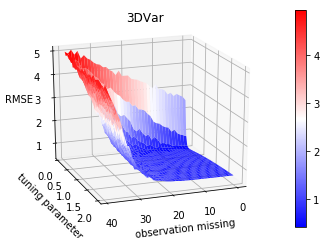

In [11]:
from mpl_toolkits.mplot3d import Axes3D

x2=np.array([0.05*(i+1) for i in range(40)])
x1=np.array([i for i in range(40)])
X1,X2 = np.meshgrid(x1,x2)

dataset = pd.read_csv("3dVar.csv")
DATA=dataset.values
for i in range(1600):
    DATA[i,2]=float(DATA[i,2])
Y_plot = DATA[:,2].reshape(X1.T.shape)
Y_plot = Y_plot.T
print(Y_plot)

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

surf = ax.plot_surface(X1,X2,Y_plot,cmap='bwr',linewidth=0)
#plt.plot(delta,RKF,label="KF")
ax.set_xlabel("observation missing")
ax.set_ylabel("tuning parameter")
ax.set_zlabel("RMSE")
fig.colorbar(surf)
ax.set_title("3DVar")
ax.view_init(elev=20,azim=70)
plt.savefig("3DVarobsmiss.jpg")
fig.show()
#print(R3d)
#print(RKF)

[[4.336000423 4.332782472 4.446346065 ... 5.0 5.0 5.0]
 [3.9769106689999996 4.13789415 4.150453322 ... 5.0 5.0 5.0]
 [2.475970605 2.599361553 4.151622566 ... 5.0 5.0 5.0]
 ...
 [0.33628443799999996 0.34130021899999996 0.346562737 ... 5.0 5.0 5.0]
 [0.340103651 0.34555374 0.35044717299999995 ... 5.0 5.0 5.0]
 [0.343861507 0.349182738 0.353525236 ... 5.0 5.0 5.0]]


C:\Users\saori\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


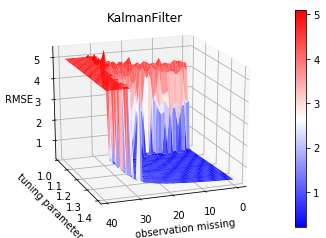

In [12]:
from mpl_toolkits.mplot3d import Axes3D

dataset = pd.read_csv("KF.csv")
dataset2 = pd.read_csv("KF2.csv")
dataset3 = pd.concat([dataset,dataset2],ignore_index=True)
DATA = dataset3.values
#print(DATA[839,2].count(" "))
for i in range(1600):
    if((type(DATA[i,2])==str)and(DATA[i,2].count(" ")>20)):
        DATA[i,2]=5.0
    else:
        DATA[i,2]=float(DATA[i,2])
        
x2=np.array([1.0+0.01*(i+1) for i in range(40)])
x1=np.array([i for i in range(40)])
X1,X2 = np.meshgrid(x1,x2)

Y_plot = DATA[:,2].reshape(X1.T.shape)
Y_plot = Y_plot.T
print(Y_plot)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

surf = ax.plot_surface(X1,X2,Y_plot,cmap='bwr',linewidth=0)
#ax.scatter3D(np.ravel(X1),np.ravel(X2),Y_plot)
#plt.plot(delta,RKF,label="KF")
ax.set_xlabel("observation missing")
ax.set_ylabel("tuning parameter")
ax.set_zlabel("RMSE")
fig.colorbar(surf)
ax.set_title("KalmanFilter")
ax.view_init(elev=20,azim=70)
plt.savefig("KFobsmiss.jpg")
fig.show()

[[2.44701947 0.86344067 0.46583121 ... 0.69470023 0.69927331 0.70370631]
 [2.61707887 0.9187472  0.49091432 ... 0.6964651  0.69919079 0.70302003]
 [2.68370385 0.96268068 0.49647814 ... 0.69521891 0.70089585 0.70400155]
 ...
 [5.0831631  4.60394098 4.49357822 ... 4.21188031 4.25464965 4.22096024]
 [4.93023488 4.9311929  4.90615431 ... 4.4774625  4.56677812 4.41973347]
 [5.02370501 4.88394503 5.02107344 ... 4.72148906 4.93560008 4.75910781]]
[0.402307295, 0.410300733, 0.412651836, 0.420188945, 0.42436398299999994, 0.431760039, 0.442238866, 0.453359745, 0.448940959, 0.460580135, 0.479746447, 0.489202305, 0.494092125, 0.509485381, 0.514024766, 0.530359635, 0.558288921, 0.573877947, 0.591071197, 0.600457324, 0.6334691889999999, 0.6543616520000001, 0.685308274, 0.7289798959999999, 0.798517151, 0.830374365, 0.887843898, 1.019238168, 1.057752858, 1.31851678, 1.5020984530000001, 1.7660197880000001, 2.112901499, 2.43154567, 2.780116198, 3.2950279389999997, 3.608941852, 4.089730805, 4.379323609, 

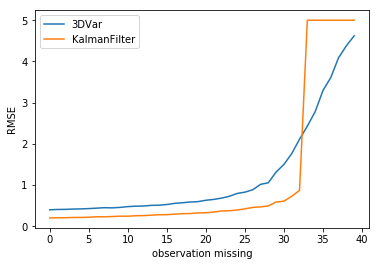

In [9]:
dataset = pd.read_csv("3dVar.csv")
DATA=dataset.values
for i in range(1600):
    DATA[i,2]=float(DATA[i,2])
Y_plot = DATA[:,2].reshape(40,40)
#Y_plot = Y_plot.T
print(Y_plot)

X3d = [min(Y_plot[i,:]) for i in range(40)]
print(X3d)

dataset = pd.read_csv("KF.csv")
dataset2 = pd.read_csv("KF2.csv")
dataset3 = pd.concat([dataset,dataset2],ignore_index=True)
DATA = dataset3.values
for i in range(1600):
    if((type(DATA[i,2])==str)and(DATA[i,2].count(" ")>20)):
        DATA[i,2]=5.0
    else:
        DATA[i,2]=float(DATA[i,2])
Y_plot2 = DATA[:,2].reshape(40,40)
print(Y_plot2)

XKF = [min(Y_plot2[i,:]) for i in range(40)]
print(XKF)

plt.plot(X3d,label="3DVar")
plt.plot(XKF,label="KalmanFilter")
plt.legend()
plt.xlabel("observation missing")
plt.ylabel("RMSE")
plt.show()

### NMC法

In [27]:
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,Pa,B,N):
    h = 0.01 
    F = 8.0
    
    X1 = Xa
    #M = np.eye(N)
    for i in range(5):
        Xf = Rungekutta4(X1,h,F)
        #M_ = get_linear(X1,h,F)
        #M = M_ @ M
        X1 = Xf
    
    #M = get_linear(Xa,h,F,N)
    Pf = B #カルマンフィルターでは時間発展する、3次元変分法では定数
    
    
    return Xf,Pf

def Analysis(Xf,Pf,y,N,m,a):
    p = N-a
    matrix = np.identity(N)
    df = pd.DataFrame(matrix) 
    df2 = df.drop(m) #観測欠損
    H = df2.values #観測行列
    R = np.eye(p)
    I = np.eye(N)
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    
    Xa = Xf + K @ (y - H @ Xf)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Pa


def NMC(a):
    t = 1460
    N = 40
    h = 0.01 
    F = 8.0
    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    Pa = np.eye(N) * 25
    #print(Xa)
    #print(Pa)
    
    X = []
    B = np.eye(N)
    for k in range(t):
         #観測を減らす
        dataset = pd.read_csv("observation_data.csv")    
        l = np.arange(N).tolist()
        m = random.sample(l,a)
        for i in range(a):
            df = dataset.drop(str(m[i]),axis=1)
            dataset = df
        y = dataset.values 
        y = y.reshape(1460,N-a)
        (Xf,Pf) = Forecast(Xa,Pa,B,N)
        (Xa,Pa) = Analysis(Xf,Pf,y[k,:],N,m,a)
        X.append(Xa)
    
    XA = np.array(X).reshape(t,N)
    dX = np.array([M8(XA[i,:],h,F)-M4(XA[i,:],h,F) for i in range(500,t)])
    #print(dX.shape)
    Pf = dX.T @ dX /(t-500)
            
    return Pf

def M8(X,h,F):
    for i in range(8):
        Xf = Rungekutta4(X,h,F)
        X = Xf
    return X

def M4(X,h,F):
    for i in range(4):
        Xf = Rungekutta4(X,h,F)
        X = Xf
    return X


In [43]:
B = np.array(Pf)
print("B",B)
A = B.reshape(1600,40)
print("A",A)
df = pd.DataFrame(A)
print(df)
df.to_csv("NMC.csv",index=False)

B [[[ 4.79330747e-01  4.20872090e-03 -1.29577136e-01 ... -9.12297778e-02
   -1.21632363e-01  3.02404492e-03]
  [ 4.20872090e-03  4.45387094e-01 -7.82795659e-03 ... -3.82992082e-02
   -5.14938032e-02 -8.68936835e-02]
  [-1.29577136e-01 -7.82795659e-03  5.90013209e-01 ...  3.40171481e-02
   -6.25370329e-02  1.88409329e-02]
  ...
  [-9.12297778e-02 -3.82992082e-02  3.40171481e-02 ...  5.62464940e-01
   -3.56017749e-02 -1.32793003e-01]
  [-1.21632363e-01 -5.14938032e-02 -6.25370329e-02 ... -3.56017749e-02
    5.46725101e-01  2.99626507e-02]
  [ 3.02404492e-03 -8.68936835e-02  1.88409329e-02 ... -1.32793003e-01
    2.99626507e-02  5.58098604e-01]]

 [[ 4.81081104e-01  5.47732789e-03 -1.28174102e-01 ... -8.94995020e-02
   -1.21758853e-01  6.30058172e-04]
  [ 5.47732789e-03  4.46537636e-01 -7.29837866e-03 ... -4.19127410e-02
   -4.86949613e-02 -8.62197562e-02]
  [-1.28174102e-01 -7.29837866e-03  5.89308884e-01 ...  3.27818231e-02
   -6.18340342e-02  2.03611967e-02]
  ...
  [-8.94995020e-02 -4

In [24]:
N=40
a=20
dataset = pd.read_csv("observation_data.csv")
print(dataset)
#観測を減らす
l = np.arange(N).tolist()
m = random.sample(l,a)
print(m)
for i in range(a):
    df = dataset.drop(str(m[i]),axis=1)
    dataset = df
df
matrix = np.identity(N)
df = pd.DataFrame(matrix) #観測欠損
df2 = df.drop(m)
df = df2
df

             0          1          2         3         4         5         6  \
0    -5.425581  -1.423854  -0.150119  1.261217  5.590178 -2.308530 -2.513758   
1    -4.694844  -0.577621   1.611166  0.312424  6.558577 -1.004480 -3.125805   
2    -1.686841  -2.554148  -0.872909  0.910991  6.799172 -1.305137 -2.086903   
3     1.115870   0.303364  -0.598635  1.835806  6.685576 -1.899905 -0.932762   
4    -1.118425  -1.262545   1.122746  2.908984  4.202689 -1.928357 -0.101053   
5     4.767104  -1.879523   0.499339  3.966196  6.746950 -2.975275  1.317967   
6     3.024511   1.623390   0.896185  3.645252  5.976058 -2.452152  4.105747   
7     2.402285   0.227137   2.307421  3.428512  5.708995 -1.953765  3.428261   
8     2.275307   1.086698   2.287801  3.774172  4.544487 -0.824972  3.403007   
9     1.293025   2.186522   1.368865  3.588509  4.932824 -0.492253  1.911273   
10    2.651798   1.269654   2.548026  5.073459  3.677067 -1.416203  4.010146   
11    2.944124   2.674432   3.093402  5.

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
import time

def get_linear_py(Xa,h,F,N):
    d = 0.00001
    E = np.eye(N)
    MT = []
    MT = [(Rungekutta4(Xa+d*E[j],h,F)-Rungekutta4(Xa,h,F))/d for j in range(N)]
        
    M = np.array(MT).reshape(N,N)
    M = M.T
    return M
        
    M = np.array(MT).reshape(N,N)
    M = M.T
    return M

h=0.05
F=8.0
N=40
X=np.random.randn(N)
starttime = time.time()
M = get_linear_py(X,h,F,N)
proc_time_python = time.time() - starttime
print('python',proc_time_python)

python 0.04686260223388672


In [2]:
%load_ext Cython

In [18]:
%%cython -a
import numpy as np
cimport numpy as np
DTYPE = np.double
ctypedef np.double_t DTYPE_t

def L96(np.ndarray[DTYPE_t,ndim=1] Xa,double F):
    cdef int N=len(Xa)
    cdef np.ndarray[DTYPE_t,ndim=1] F_
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(np.ndarray[DTYPE_t,ndim=1] Xa,double h,double F):
    cdef int N=len(Xa)
    cdef np.ndarray[DTYPE_t,ndim=1] F_,K1,K2,K3,K4,X2,X3,X4,Xb
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def get_linear_cy(np.ndarray[DTYPE_t,ndim=1] Xa,double h,double F,int N):
    cdef double d = 0.00001
    cdef np.ndarray[DTYPE_t,ndim=2] E = np.identity(N)
    cdef list MT = []
    cdef int i,j
    cdef np.ndarray[DTYPE_t,ndim=1] ej,X2,X3,M1,M2,M3
    cdef np.ndarray[DTYPE_t,ndim=2] M=np.empty((N,N))
    for j in range(N):
        ej = E[j]
        X2 = Xa + d*ej
        X3 = Xa
        for i in range(5):
            M1 = Rungekutta4(X2,h,F)
            M2 = Rungekutta4(X3,h,F)
            X2 = M1
            X3 = M2
        M3 = (M1-M2)/d
        MT.append(M3)
        
    M = np.ndarray(MT).reshape(N,N)
    M = M.T
    return M


In [20]:
h=0.05
F=8.0
N=40
X=np.random.randn(N)
starttime = time.time()
M = np.empty((len(X),len(X)))
M = get_linear_cy(X,h,F,N)
proc_time_cython = time.time() - starttime
print('cython',proc_time_cython)

ValueError: sequence too large; cannot be greater than 32